# (03) DCI vs. $\beta$ (KABA)

**Motivation**: Using fits existing on KABA <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from analysis.linear import compute_dci
from base.utils_model import load_model


def grad_table(tr: TrainerVAE, clip: float = None, thresholds: List[float] = None):
    thresholds = thresholds if thresholds else [
        1, 2, 5, 10, 20, 50, 100, 200]
    clip = clip if clip else tr.cfg.grad_clip
    thresholds = [
        clip * i for i
        in thresholds
    ]
    bad = np.array(list(tr.stats['grad'].values()))

    t = PrettyTable(['Threshold', '#', '%'])
    for thres in thresholds:
        tot = (bad > thres).sum()
        perc = tot / metadata['global_step']
        perc = np.round(100 * perc, 3)
        t.add_row([int(thres), tot, perc])
    return t

## Load models

### ```Transl 2```, $\beta = 0.15$

In [3]:
tr_low, metadata = load_model(
    model_name='transl2_k-32_z-20x[3,6,12]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)',
    fit_name='ep160-b600-lr(0.002)_beta(0.15:0x0.5)_lamb(0.0001)_gr(1000.0)_(2023_04_24,16:13)',
    device='cuda:1',
    verbose=True,
)
print(f"checkpoint = {metadata['checkpoint']}")

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  23.3 Mil  |
|     ---      |    ---     |
|     stem     |    320     |
| pre_process  |  151.6 K   |
|  enc_tower   |  11.5 Mil  |
|     enc0     |   66.0 K   |
| enc_sampler  |  2.6 Mil   |
| dec_sampler  |  2.5 Mil   |
|    expand    |  351.2 K   |
|  dec_tower   |  6.0 Mil   |
| post_process |   67.9 K   |
|     out      |    578     |
+--------------+------------+

# params: 23.3 M

checkpoint = 160

### ```Transl 2```, $\beta = 1$

In [4]:
tr_high, metadata = load_model(
    model_name='transl2_k-32_z-20x[3,6,12]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)',
    fit_name='ep160-b600-lr(0.002)_beta(1:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_04_30,20:40)',
    device='cuda:2',
    verbose=True,
)
print(f"checkpoint = {metadata['checkpoint']}")

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  23.3 Mil  |
|     ---      |    ---     |
|     stem     |    320     |
| pre_process  |  151.6 K   |
|  enc_tower   |  11.5 Mil  |
|     enc0     |   66.0 K   |
| enc_sampler  |  2.6 Mil   |
| dec_sampler  |  2.5 Mil   |
|    expand    |  351.2 K   |
|  dec_tower   |  6.0 Mil   |
| post_process |   67.9 K   |
|     out      |    578     |
+--------------+------------+

# params: 23.3 M

checkpoint = 160

## Compare

### 1) Dist of weight norms

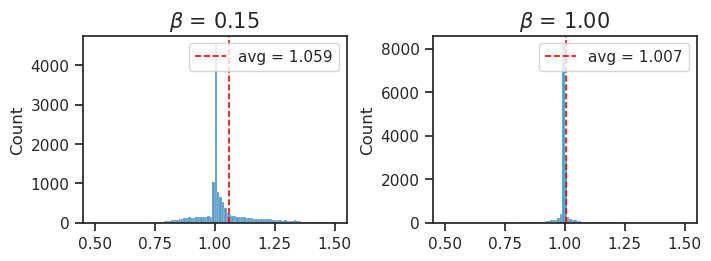

In [5]:
all_norms_low = to_np(torch.cat(tr_low.model.all_lognorm).exp())
all_norms_high = to_np(torch.cat(tr_high.model.all_lognorm).exp())
avg_norms_low = all_norms_low.mean()
avg_norms_high = all_norms_high.mean()

fig, axes = create_figure(1, 2, (7, 2.5), layout='constrained')
sns.histplot(all_norms_low, bins=np.linspace(0.5, 1.5, 101), ax=axes[0])
sns.histplot(all_norms_high, bins=np.linspace(0.5, 1.5, 101), ax=axes[1])
axes[0].axvline(avg_norms_low, color='r', ls='--', lw=1.2, label=f'avg = {avg_norms_low:0.3f}')
axes[1].axvline(avg_norms_high, color='r', ls='--', lw=1.2, label=f'avg = {avg_norms_high:0.3f}')

axes[0].set_title(r"$\beta$ = " + f"{tr_low.cfg.kl_beta:0.2f}", fontsize=15)
axes[1].set_title(r"$\beta$ = " + f"{tr_high.cfg.kl_beta:0.2f}", fontsize=15)

for ax in axes.flat:
    ax.legend()
plt.show()

### 2) Grads

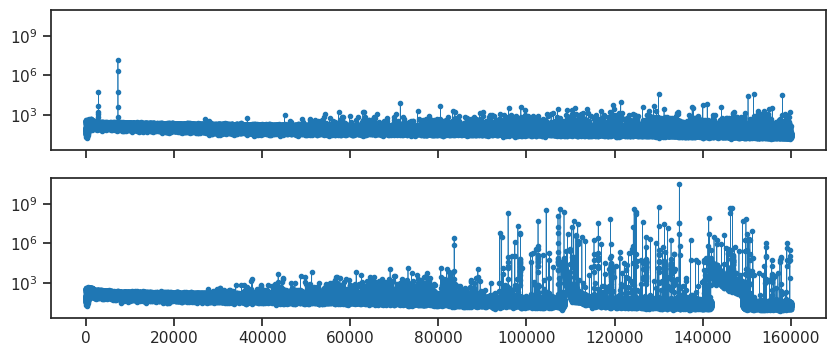

In [6]:
fig, axes = create_figure(2, 1, (10, 4), 'all', 'all')

axes[0].semilogy(tr_low.stats['grad'].keys(), tr_low.stats['grad'].values(), lw=0.5, marker='.')
axes[1].semilogy(tr_high.stats['grad'].keys(), tr_high.stats['grad'].values(), lw=0.5, marker='.')
plt.show()

In [7]:
print(grad_table(tr_low, 250), '\n')
print(grad_table(tr_high, 250), '\n')

+-----------+------+-------+
| Threshold |  #   |   %   |
+-----------+------+-------+
|    250    | 1964 | 1.228 |
|    500    | 246  | 0.154 |
|    1250   |  68  | 0.042 |
|    2500   |  31  | 0.019 |
|    5000   |  14  | 0.009 |
|   12500   |  8   | 0.005 |
|   25000   |  8   | 0.005 |
|   50000   |  4   | 0.002 |
+-----------+------+-------+

+-----------+-------+-------+
| Threshold |   #   |   %   |
+-----------+-------+-------+
|    250    | 10580 | 6.613 |
|    500    |  8195 | 5.122 |
|    1250   |  5091 | 3.182 |
|    2500   |  3337 | 2.086 |
|    5000   |  2079 | 1.299 |
|   12500   |  842  | 0.526 |
|   25000   |  324  | 0.202 |
|   50000   |  178  | 0.111 |
+-----------+-------+-------+

### 3) Losses + ELBO

In [8]:
%%time

val_low, loss_low = tr_low.validate(use_ema=False)
val_high, loss_high = tr_high.validate(use_ema=False)
# val_low_ema, loss_low_ema = tr_low.validate(use_ema=True)
# val_high_ema, loss_high_ema = tr_high.validate(use_ema=True)

CPU times: user 4min 18s, sys: 41.5 s, total: 5min
Wall time: 17min 13s


In [11]:
loss_summary_low = {
    k: {
        'vae': np.round(v.mean(), 2),
        # 'ema': np.round(loss_low_ema[k].mean(), 2),
    } for k, v in loss_low.items()
}
loss_summary_high = {
    k: {
        'vae': np.round(v.mean(), 2),
        # 'ema': np.round(loss_high_ema[k].mean(), 2),
    } for k, v in loss_high.items()
}
print(loss_summary_low)
print(loss_summary_high)

{'epe': {'vae': 3.33}, 'kl': {'vae': 50.77}}

{'epe': {'vae': 29.38}, 'kl': {'vae': 11.78}}

In [12]:
msg = f"beta = {tr_low.cfg.kl_beta},\tELBO: {loss_low['epe'].mean() + loss_low['kl'].mean():0.2f}\n"
msg += f"beta = {tr_high.cfg.kl_beta},\tELBO: {loss_high['epe'].mean() + loss_high['kl'].mean():0.2f}"
print(msg)

beta = 0.15,    ELBO: 54.11
beta = 1.0,     ELBO: 41.16

### 4) DCI

#### $\beta=0.15$

In [23]:
lr = sk_linear.LinearRegression().fit(
    val_low['z_vld'], tr_low.dl_vld.dataset.g)
pred = lr.predict(val_low['z_tst'])
r2 = sk_metric.r2_score(
    y_true=tr_low.dl_tst.dataset.g,
    y_pred=pred,
    multioutput='raw_values',
)
print(r2.mean(), '\n\n', r2)

0.4331637753418055 

 [0.99573069 0.99846703 0.96629637 0.84002144 0.64727939 0.36345956
 0.37723322 0.22414604 0.2053386  0.13446982 0.15561169 0.36526967
 0.3725976  0.2288495  0.20784082 0.12951998 0.15165278]

In [32]:
num = len(tr_low.dl_tst.dataset.f)
importances = np.zeros((num, val_low['z_vld'].shape[1]))

for i in tqdm(range(num)):
    _lr = sk_linear.LinearRegression().fit(
        val_low['z_vld'], tr_low.dl_vld.dataset.g[:, i])
    result = sk_inspect.permutation_importance(
        estimator=_lr,
        X=val_low['z_tst'],
        y=tr_low.dl_tst.dataset.g[:, i],
        n_repeats=5,
        random_state=0,
    )
    importances[i] = result.importances_mean

100%|██████████| 17/17 [34:27<00:00, 121.63s/it]


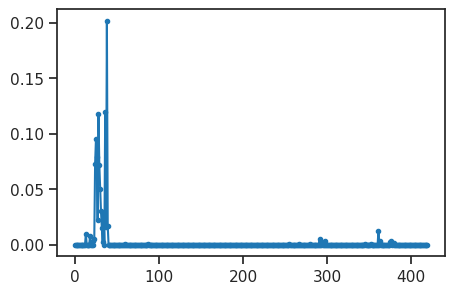

In [35]:
w = np.maximum(importances, 0)
rho = w.sum(0) / w.sum()
plt.plot(rho, marker='.')
plt.show()

In [36]:
compute_dci(w)

(0.3566677345853675, 0.6207666643909459)

In [43]:
100 * (rho > 0.001).sum() / len(rho)

6.428571428571429

#### $\beta=1.0$

In [45]:
lr = sk_linear.LinearRegression().fit(
    val_high['z_vld'], tr_high.dl_vld.dataset.g)
pred = lr.predict(val_high['z_tst'])
r2 = sk_metric.r2_score(
    y_true=tr_high.dl_tst.dataset.g,
    y_pred=pred,
    multioutput='raw_values',
)
print(r2.mean(), '\n\n', r2)

0.2772566298125878 

 [ 0.98081655  0.9801445   0.99670804  0.94141022  0.69459532  0.10165323
 -0.17913966  0.11441916  0.03395877 -0.00612671 -0.07042665  0.10248588
 -0.06122644  0.11755884 -0.01886276 -0.00548563 -0.00911997]

In [46]:
num = len(tr_high.dl_tst.dataset.f)
importances = np.zeros((num, val_high['z_vld'].shape[1]))

for i in tqdm(range(num)):
    _lr = sk_linear.LinearRegression().fit(
        val_high['z_vld'], tr_high.dl_vld.dataset.g[:, i])
    result = sk_inspect.permutation_importance(
        estimator=_lr,
        X=val_high['z_tst'],
        y=tr_high.dl_tst.dataset.g[:, i],
        n_repeats=5,
        random_state=0,
    )
    importances[i] = result.importances_mean

100%|██████████| 17/17 [31:42<00:00, 111.92s/it]


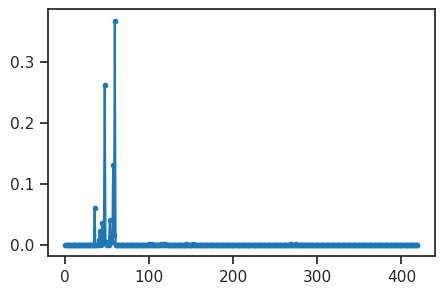

In [47]:
w = np.maximum(importances, 0)
rho = w.sum(0) / w.sum()
plt.plot(rho, marker='.')
plt.show()

In [48]:
compute_dci(w)

(0.34238025627003754, 0.6898732925448929)

In [49]:
100 * (rho > 0.001).sum() / len(rho)

3.8095238095238093

### 5) Plots

fig/sample (VAE/beta=0.15)

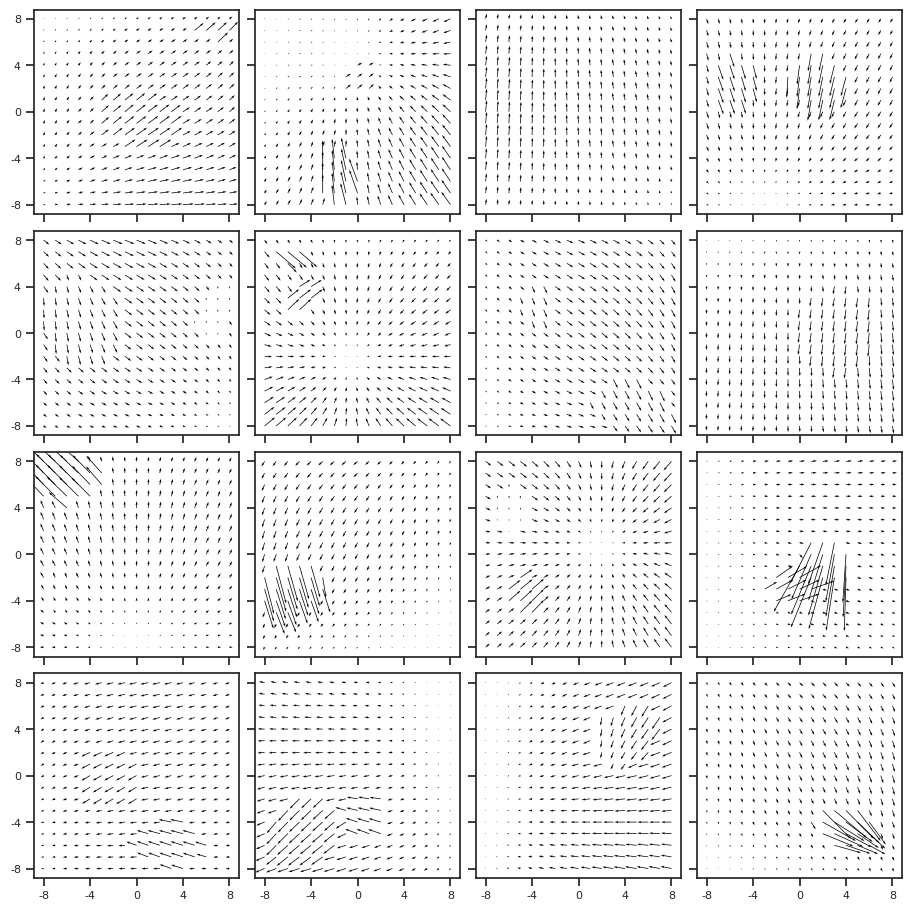

fig/sample (VAE/beta=1.0)

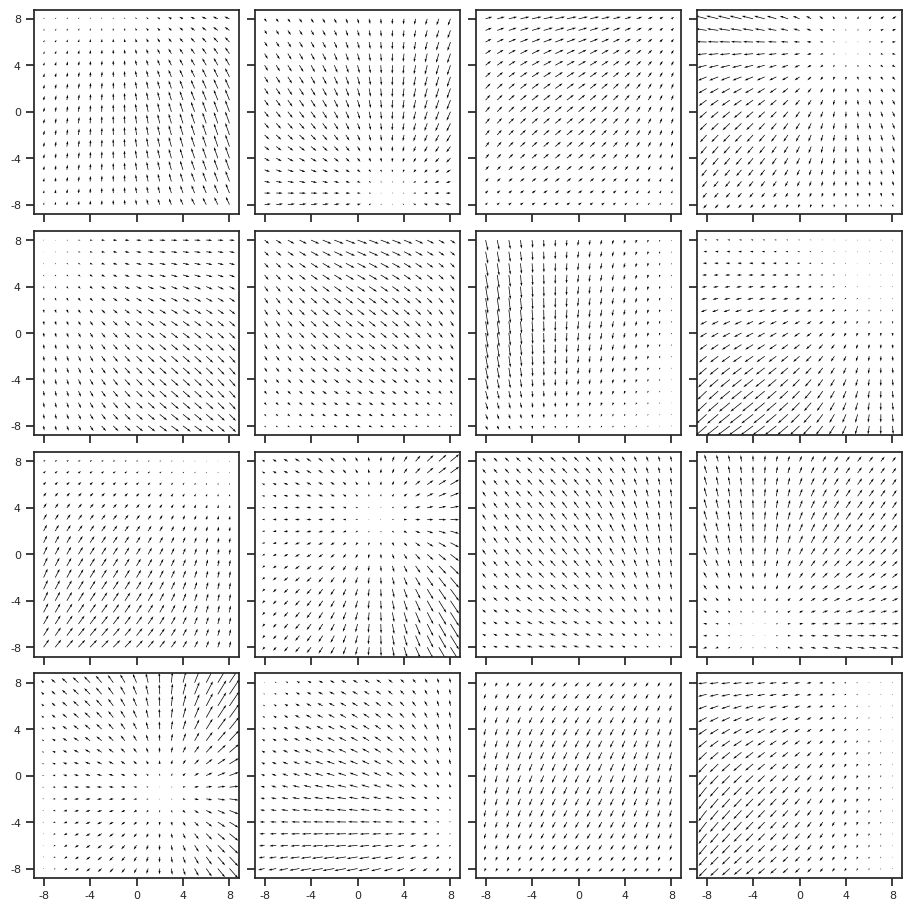

----------------------------------------------------------------------

fig/regression (VAE/beta=0.15)

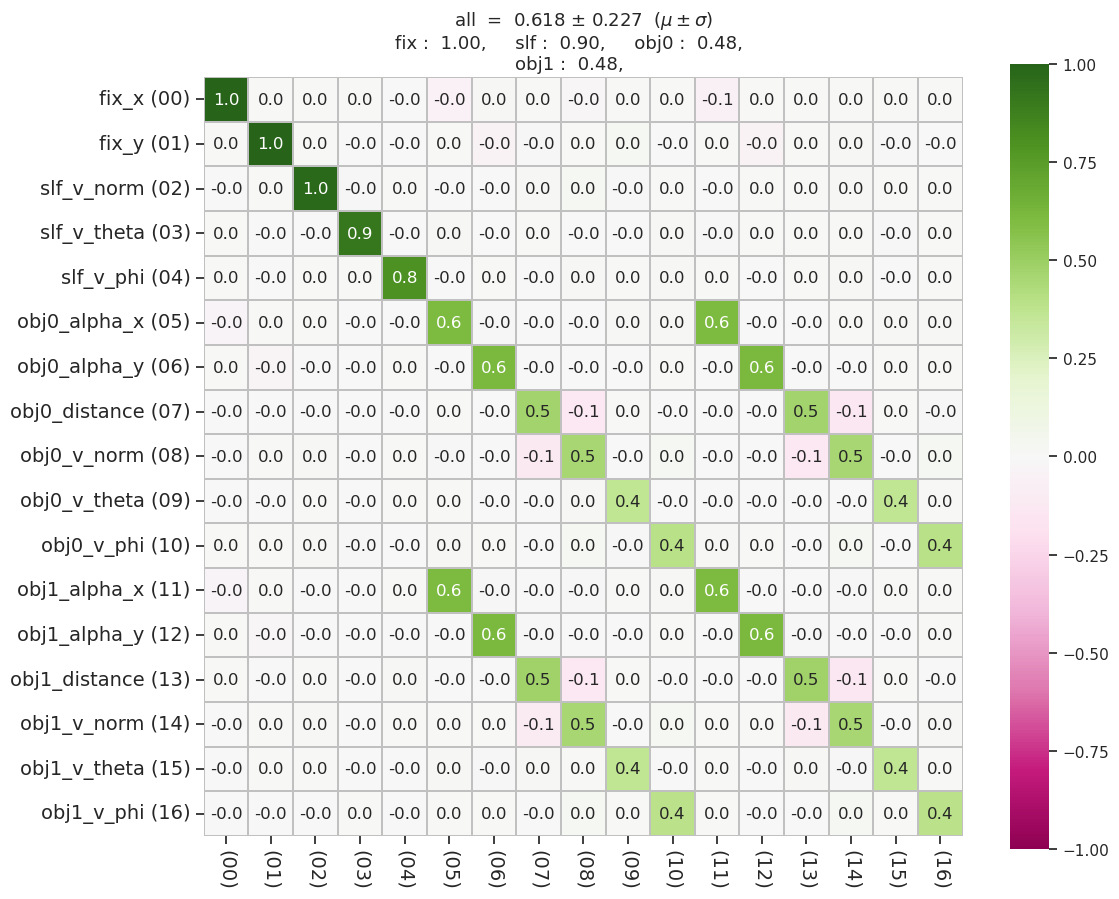

fig/regression (VAE/beta=1.0)

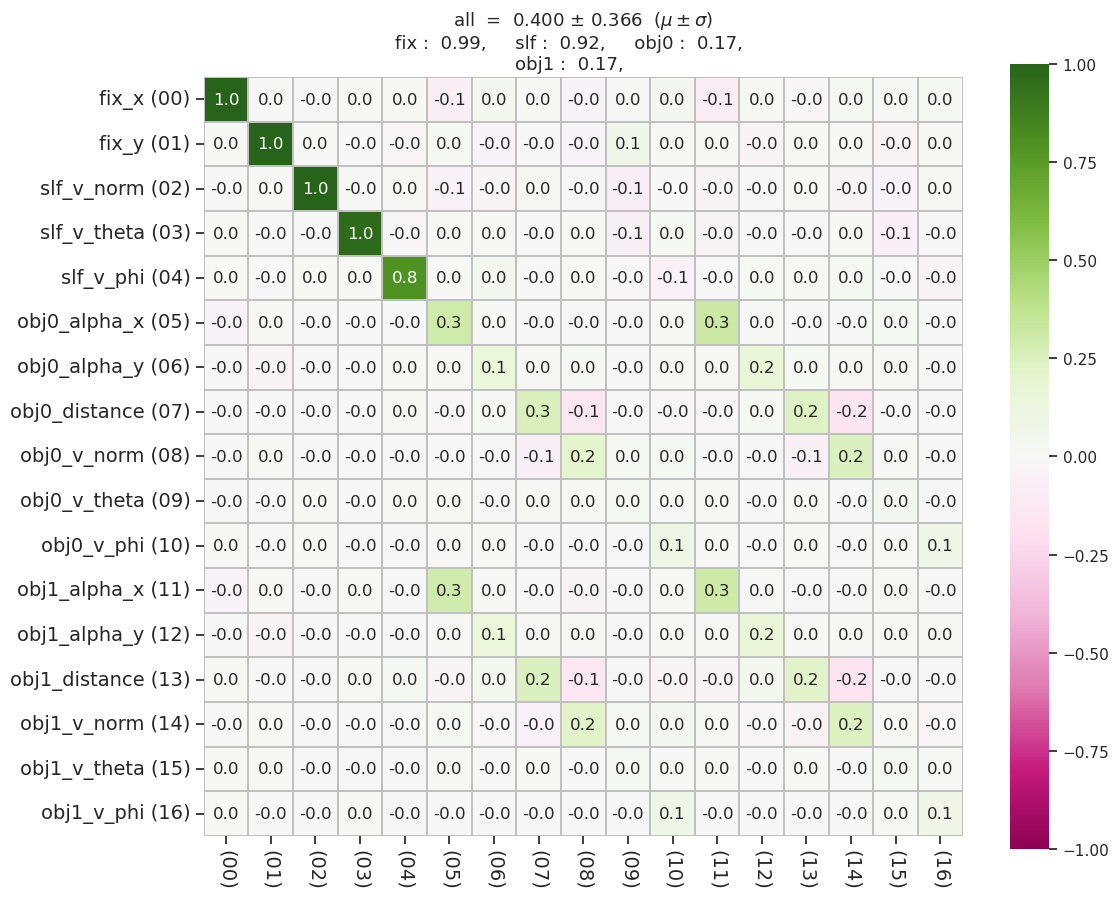

----------------------------------------------------------------------

fig/bar (VAE/beta=0.15)

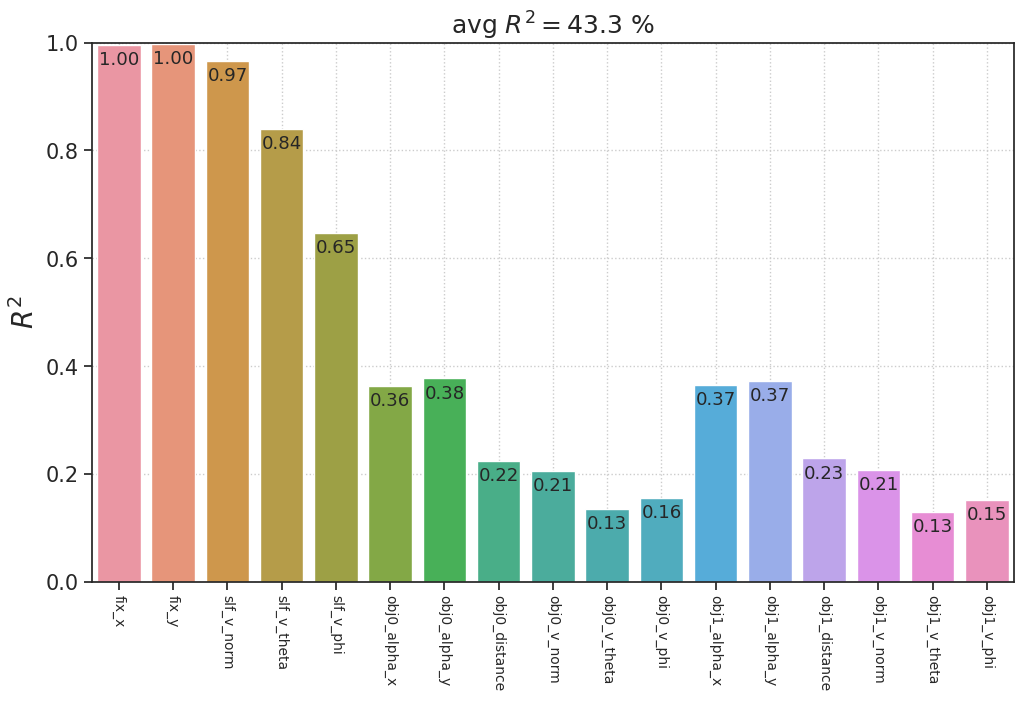

fig/bar (VAE/beta=1.0)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


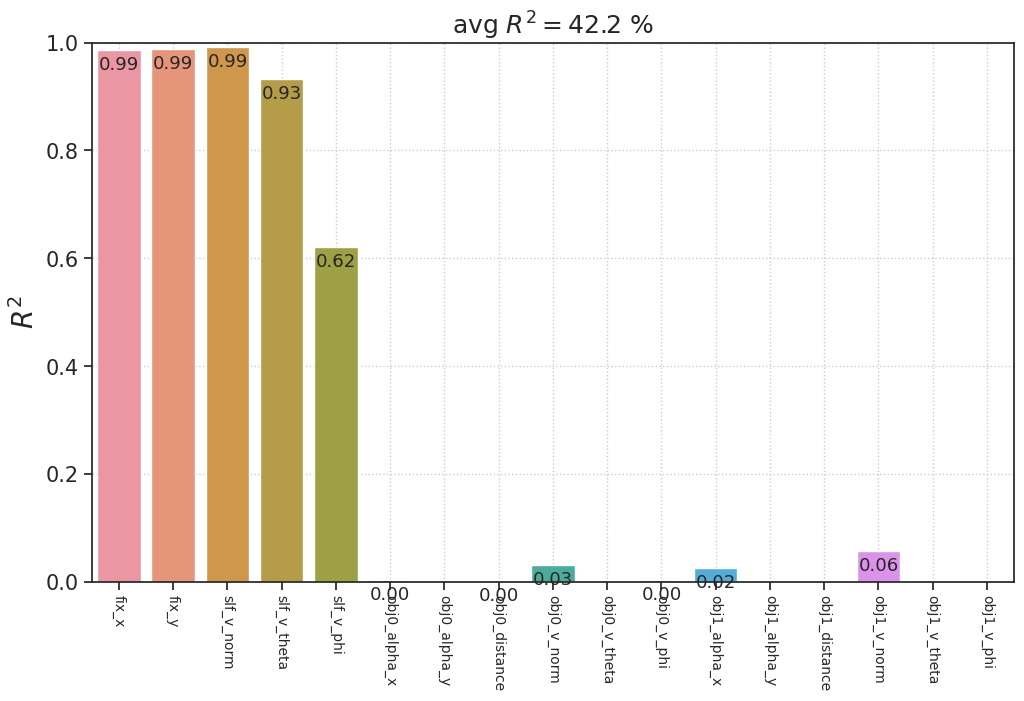

----------------------------------------------------------------------

fig/bar_aux (VAE/beta=0.15)

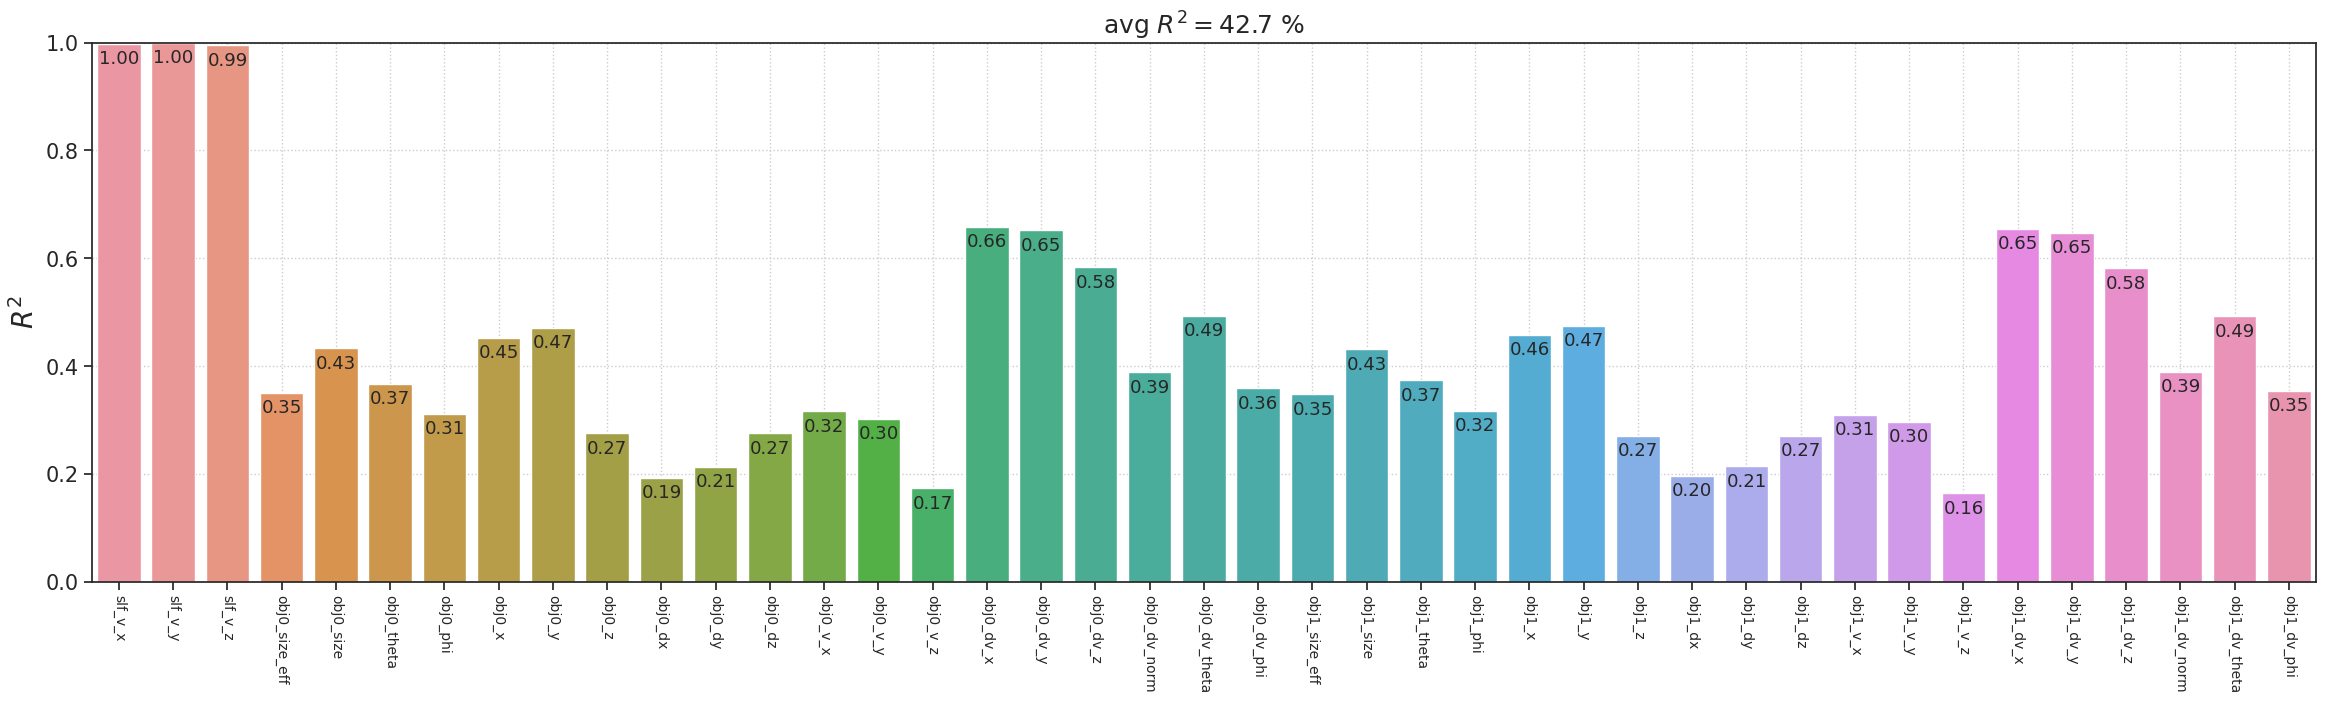

fig/bar_aux (VAE/beta=1.0)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


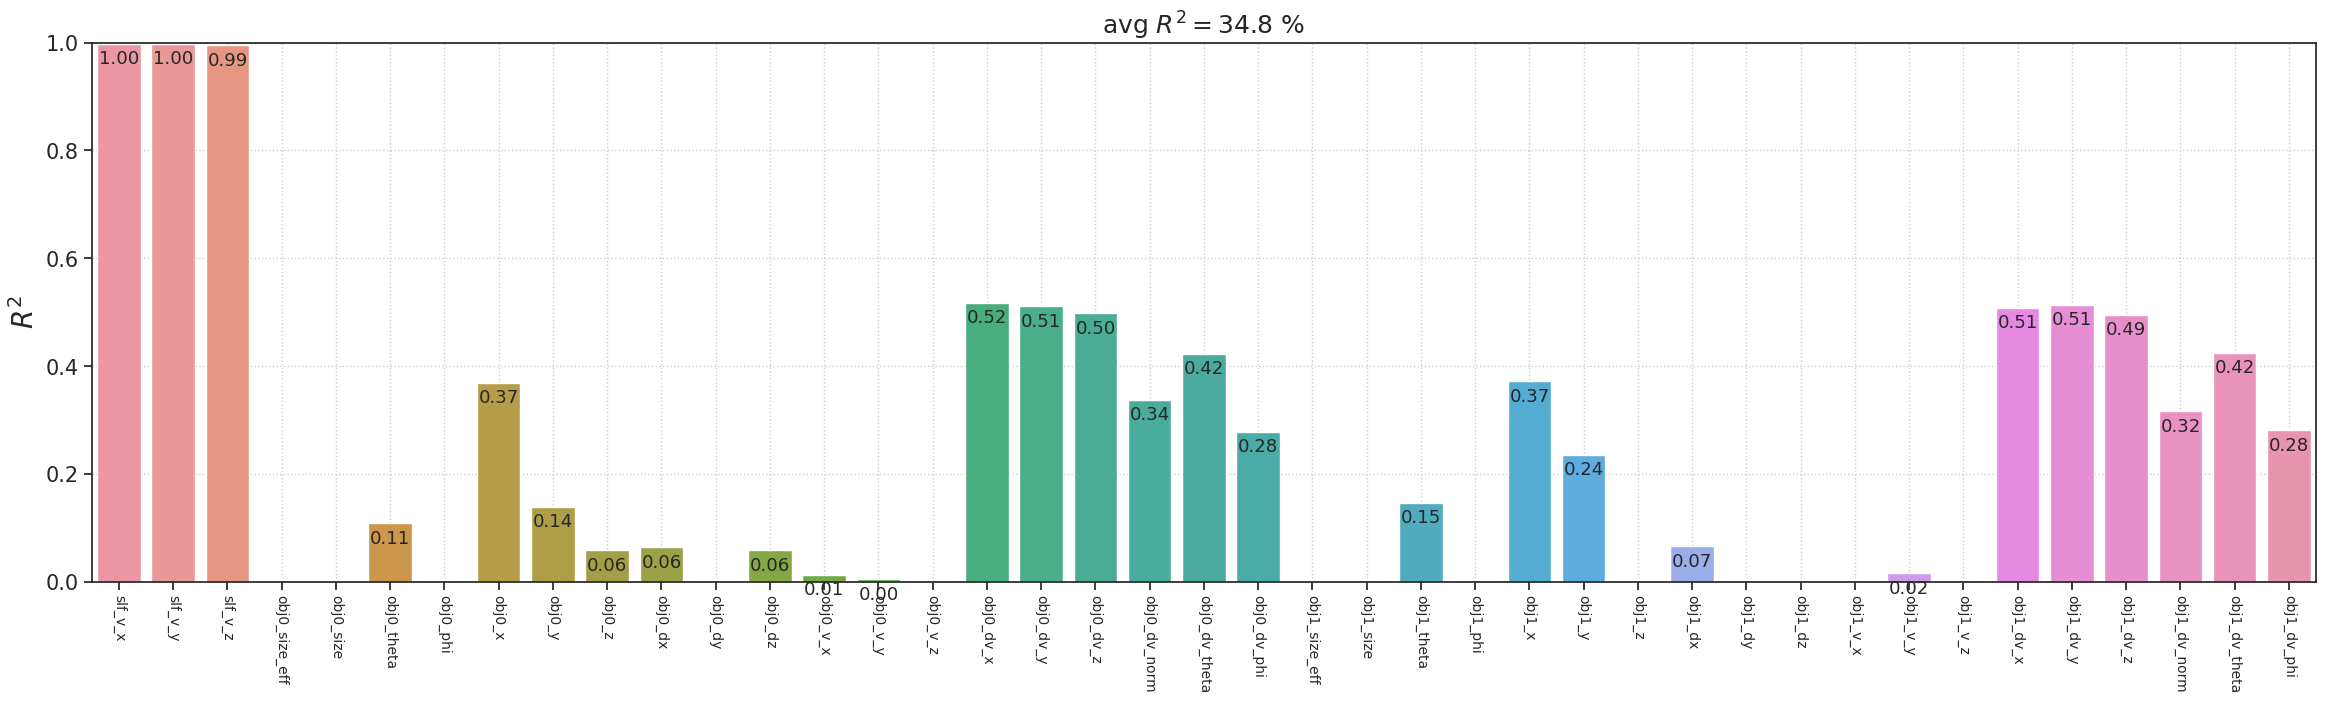

----------------------------------------------------------------------

fig/mutual_info (VAE/beta=0.15)

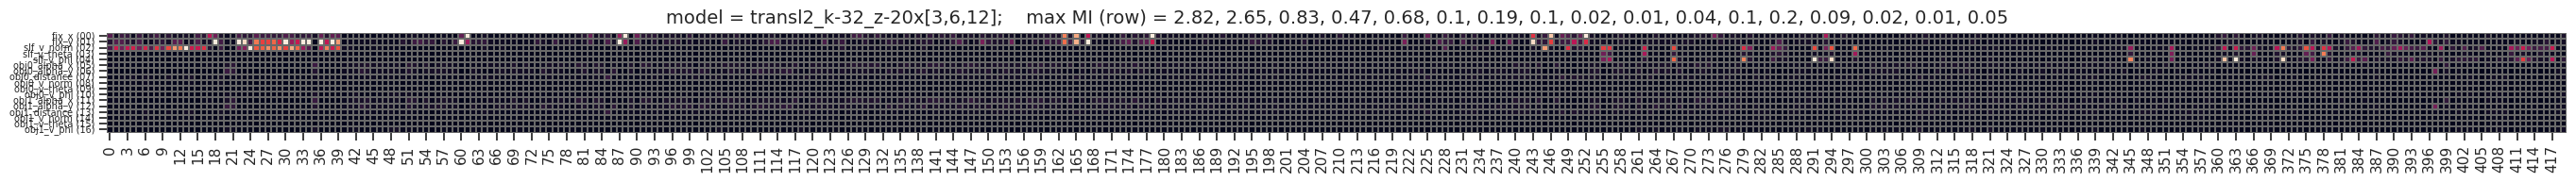

fig/mutual_info (VAE/beta=1.0)

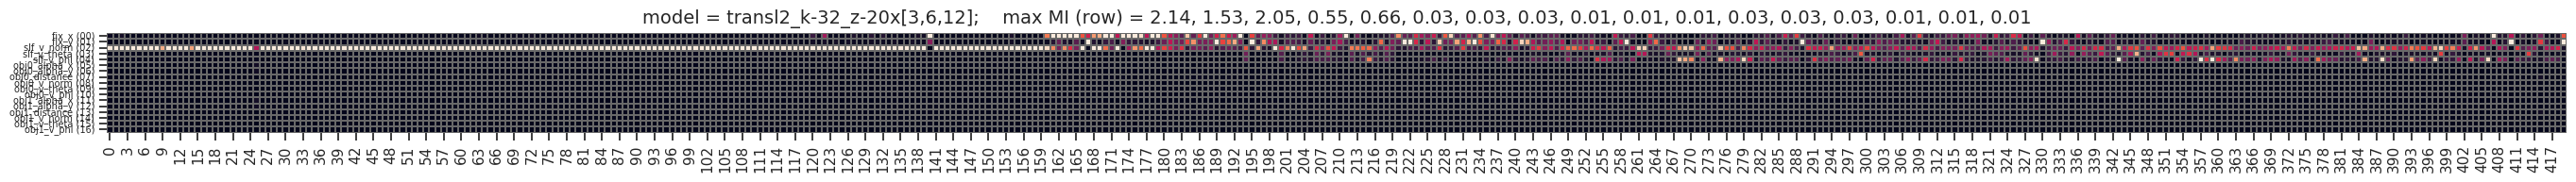

----------------------------------------------------------------------

In [30]:
for k, v in val_low.items():
    if 'fig' in k:
        print(f"{k} (VAE/beta={tr_low.cfg.kl_beta})")
        display(v)
        print(f"{k} (VAE/beta={tr_high.cfg.kl_beta})")
        display(val_high[k])
        print('-' * 70)

### 6) Hist plots

In [32]:
scales, _ = tr_low.model.latent_scales()

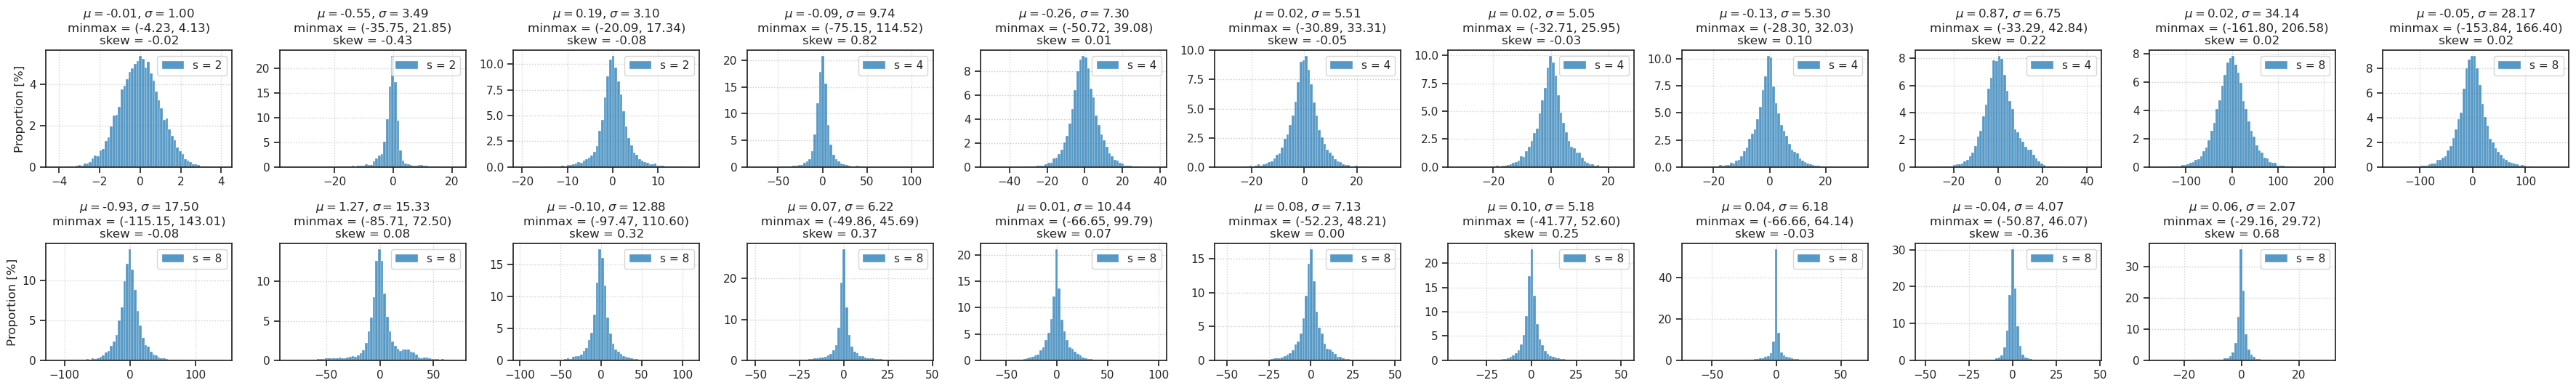

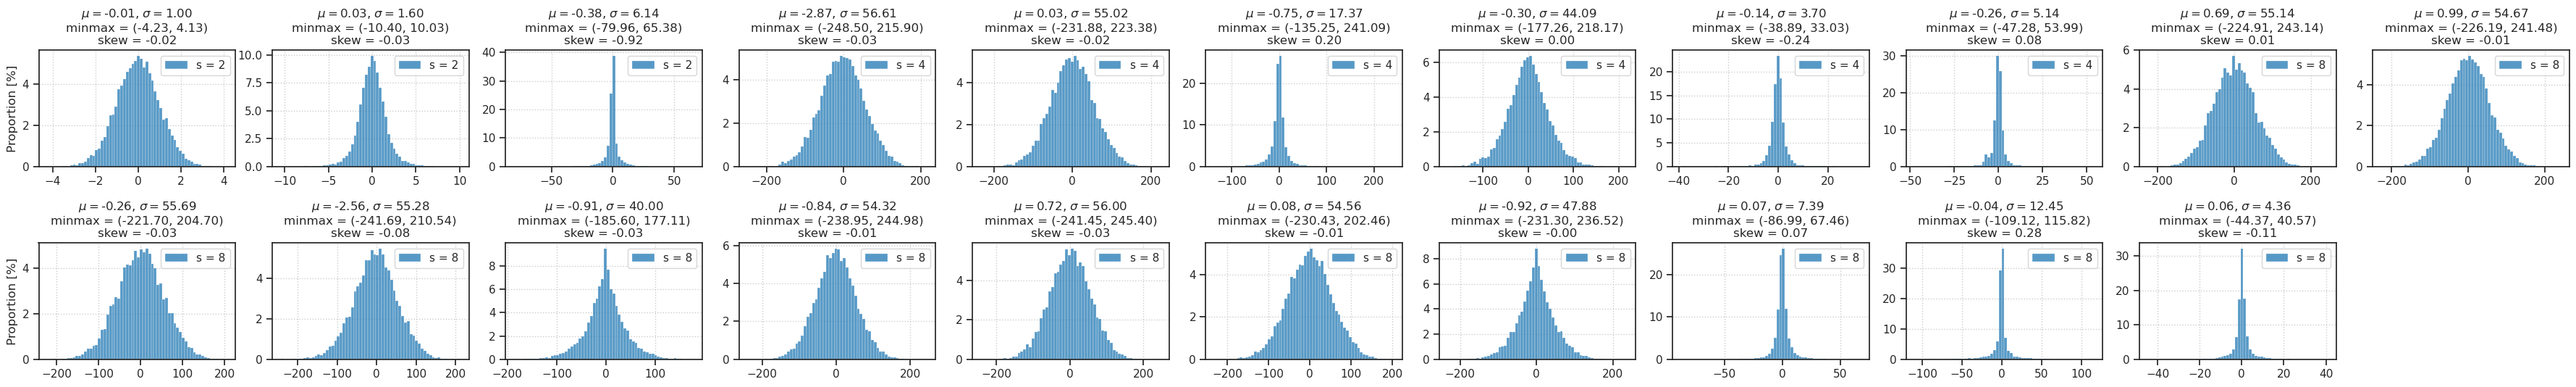

In [34]:
plot_latents_hist(val_low['z_sample'], scales);
plot_latents_hist(val_high['z_sample'], scales);

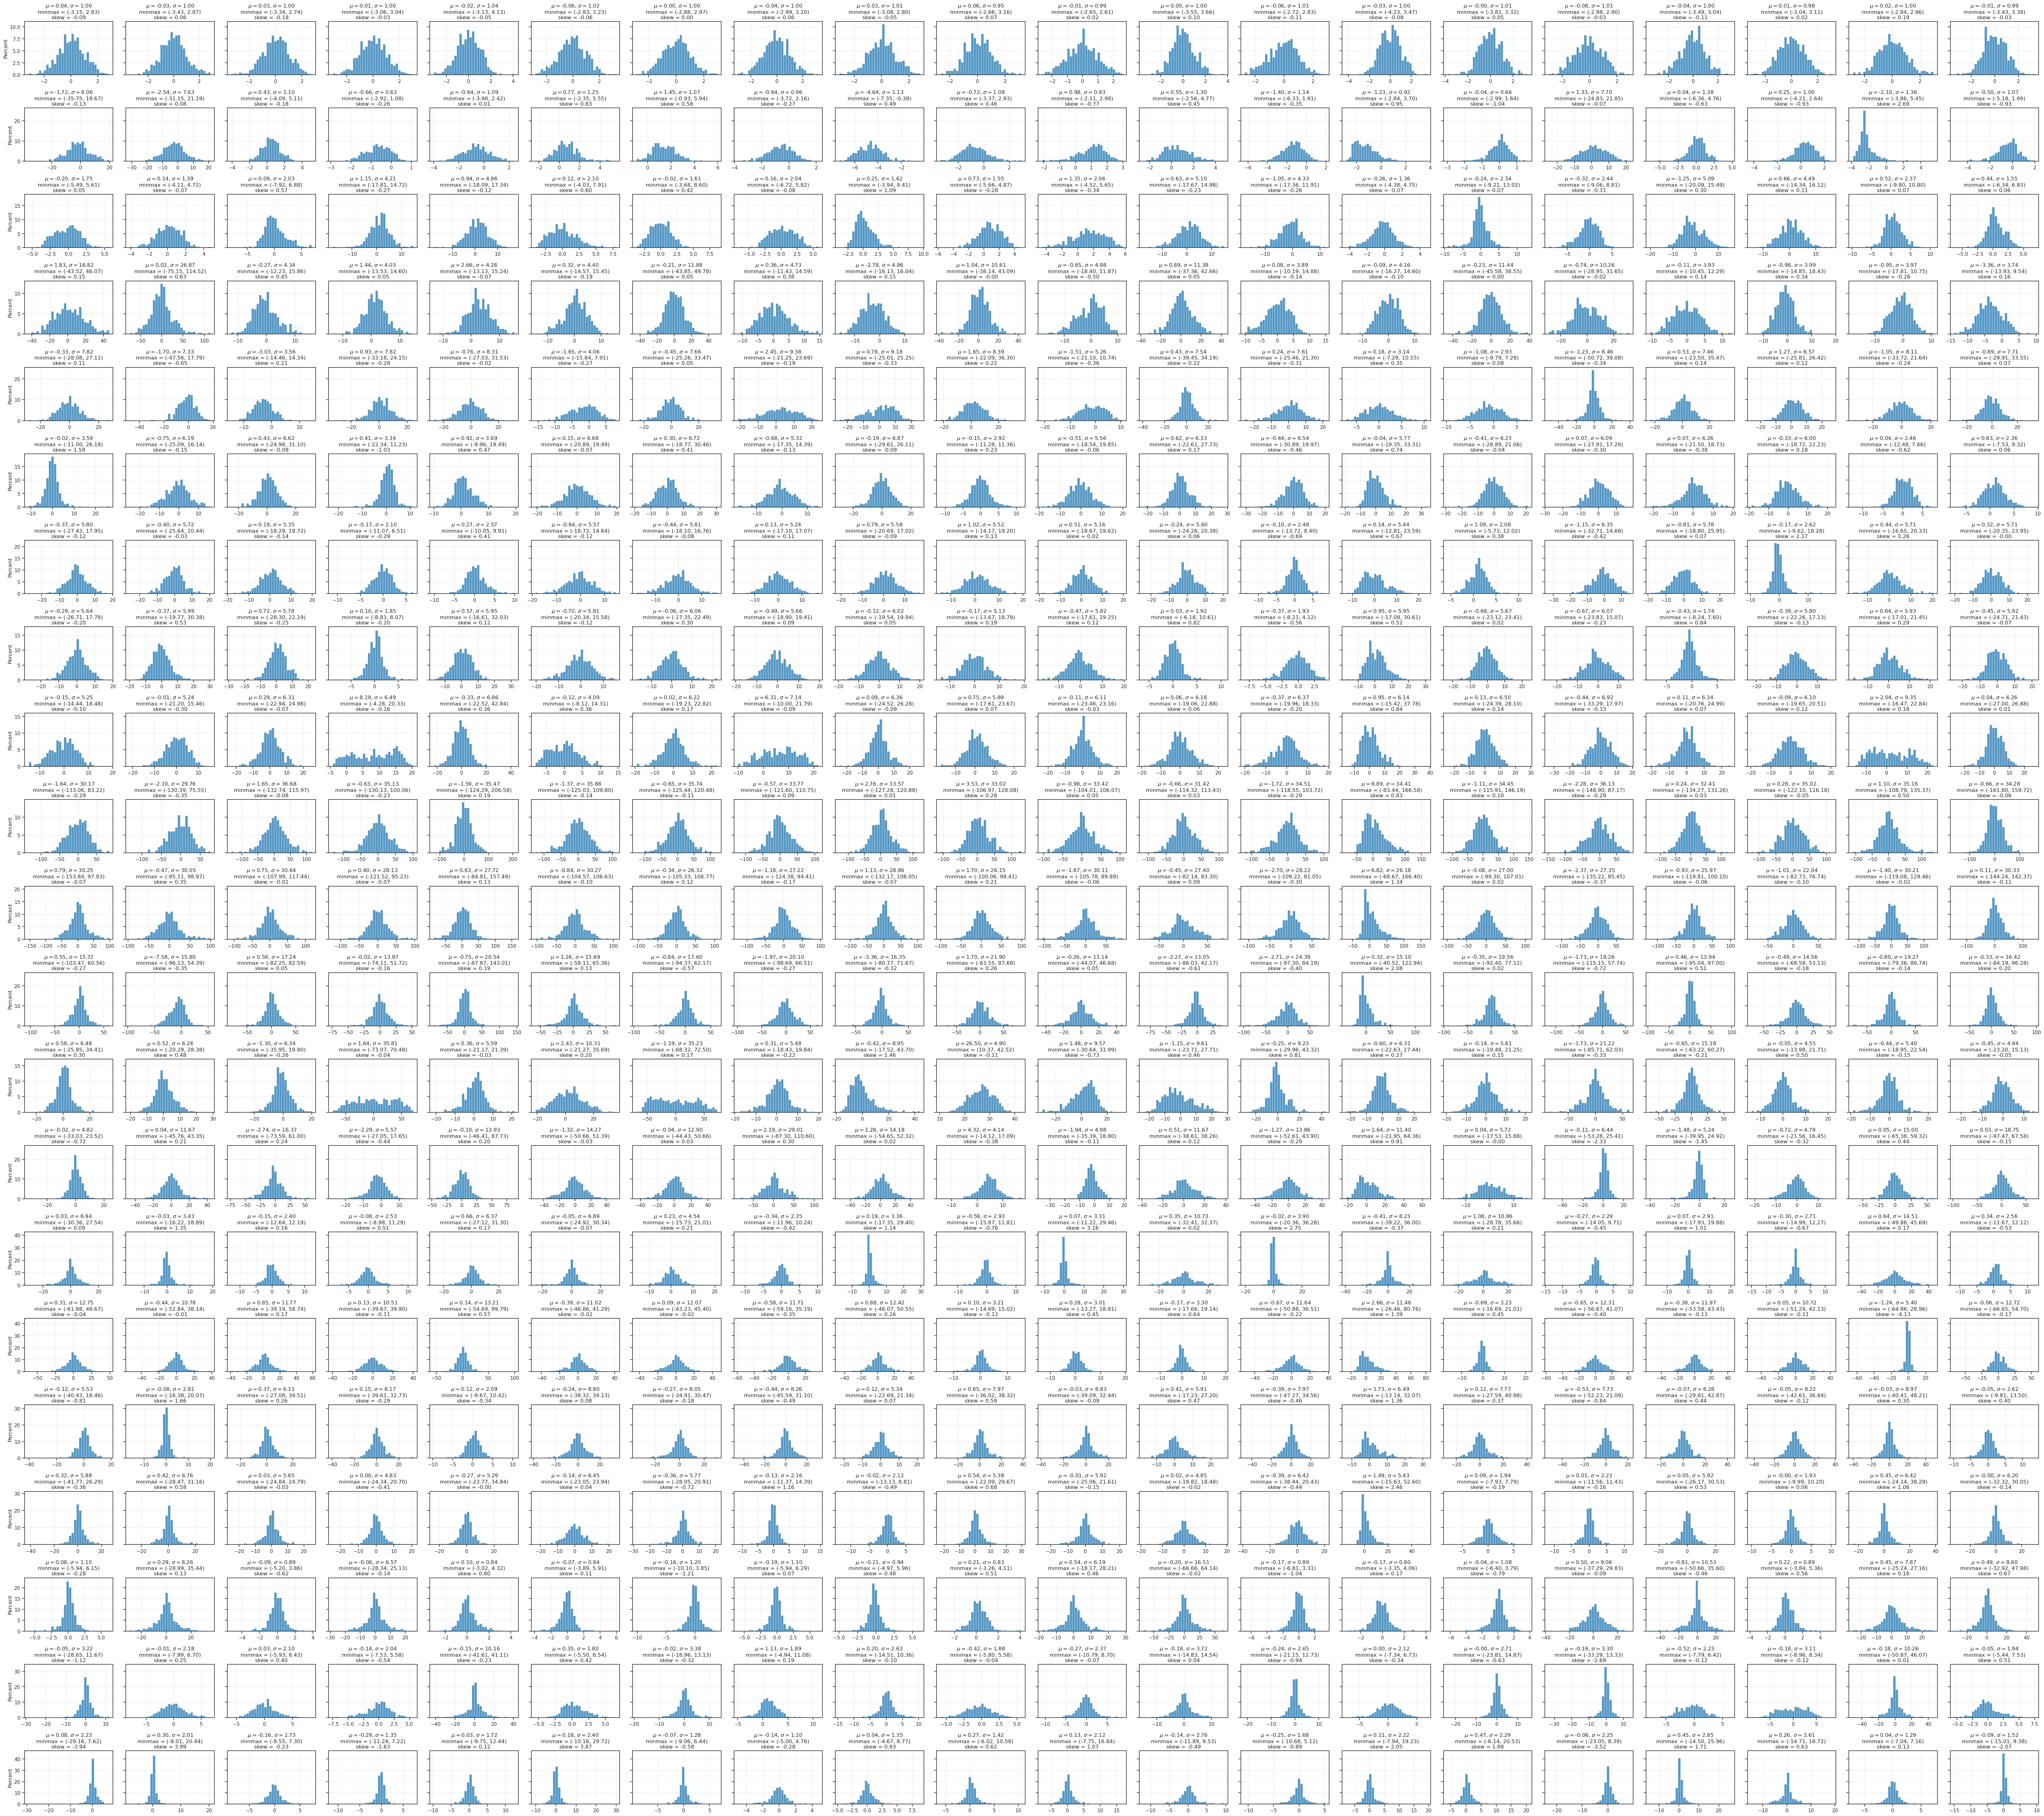

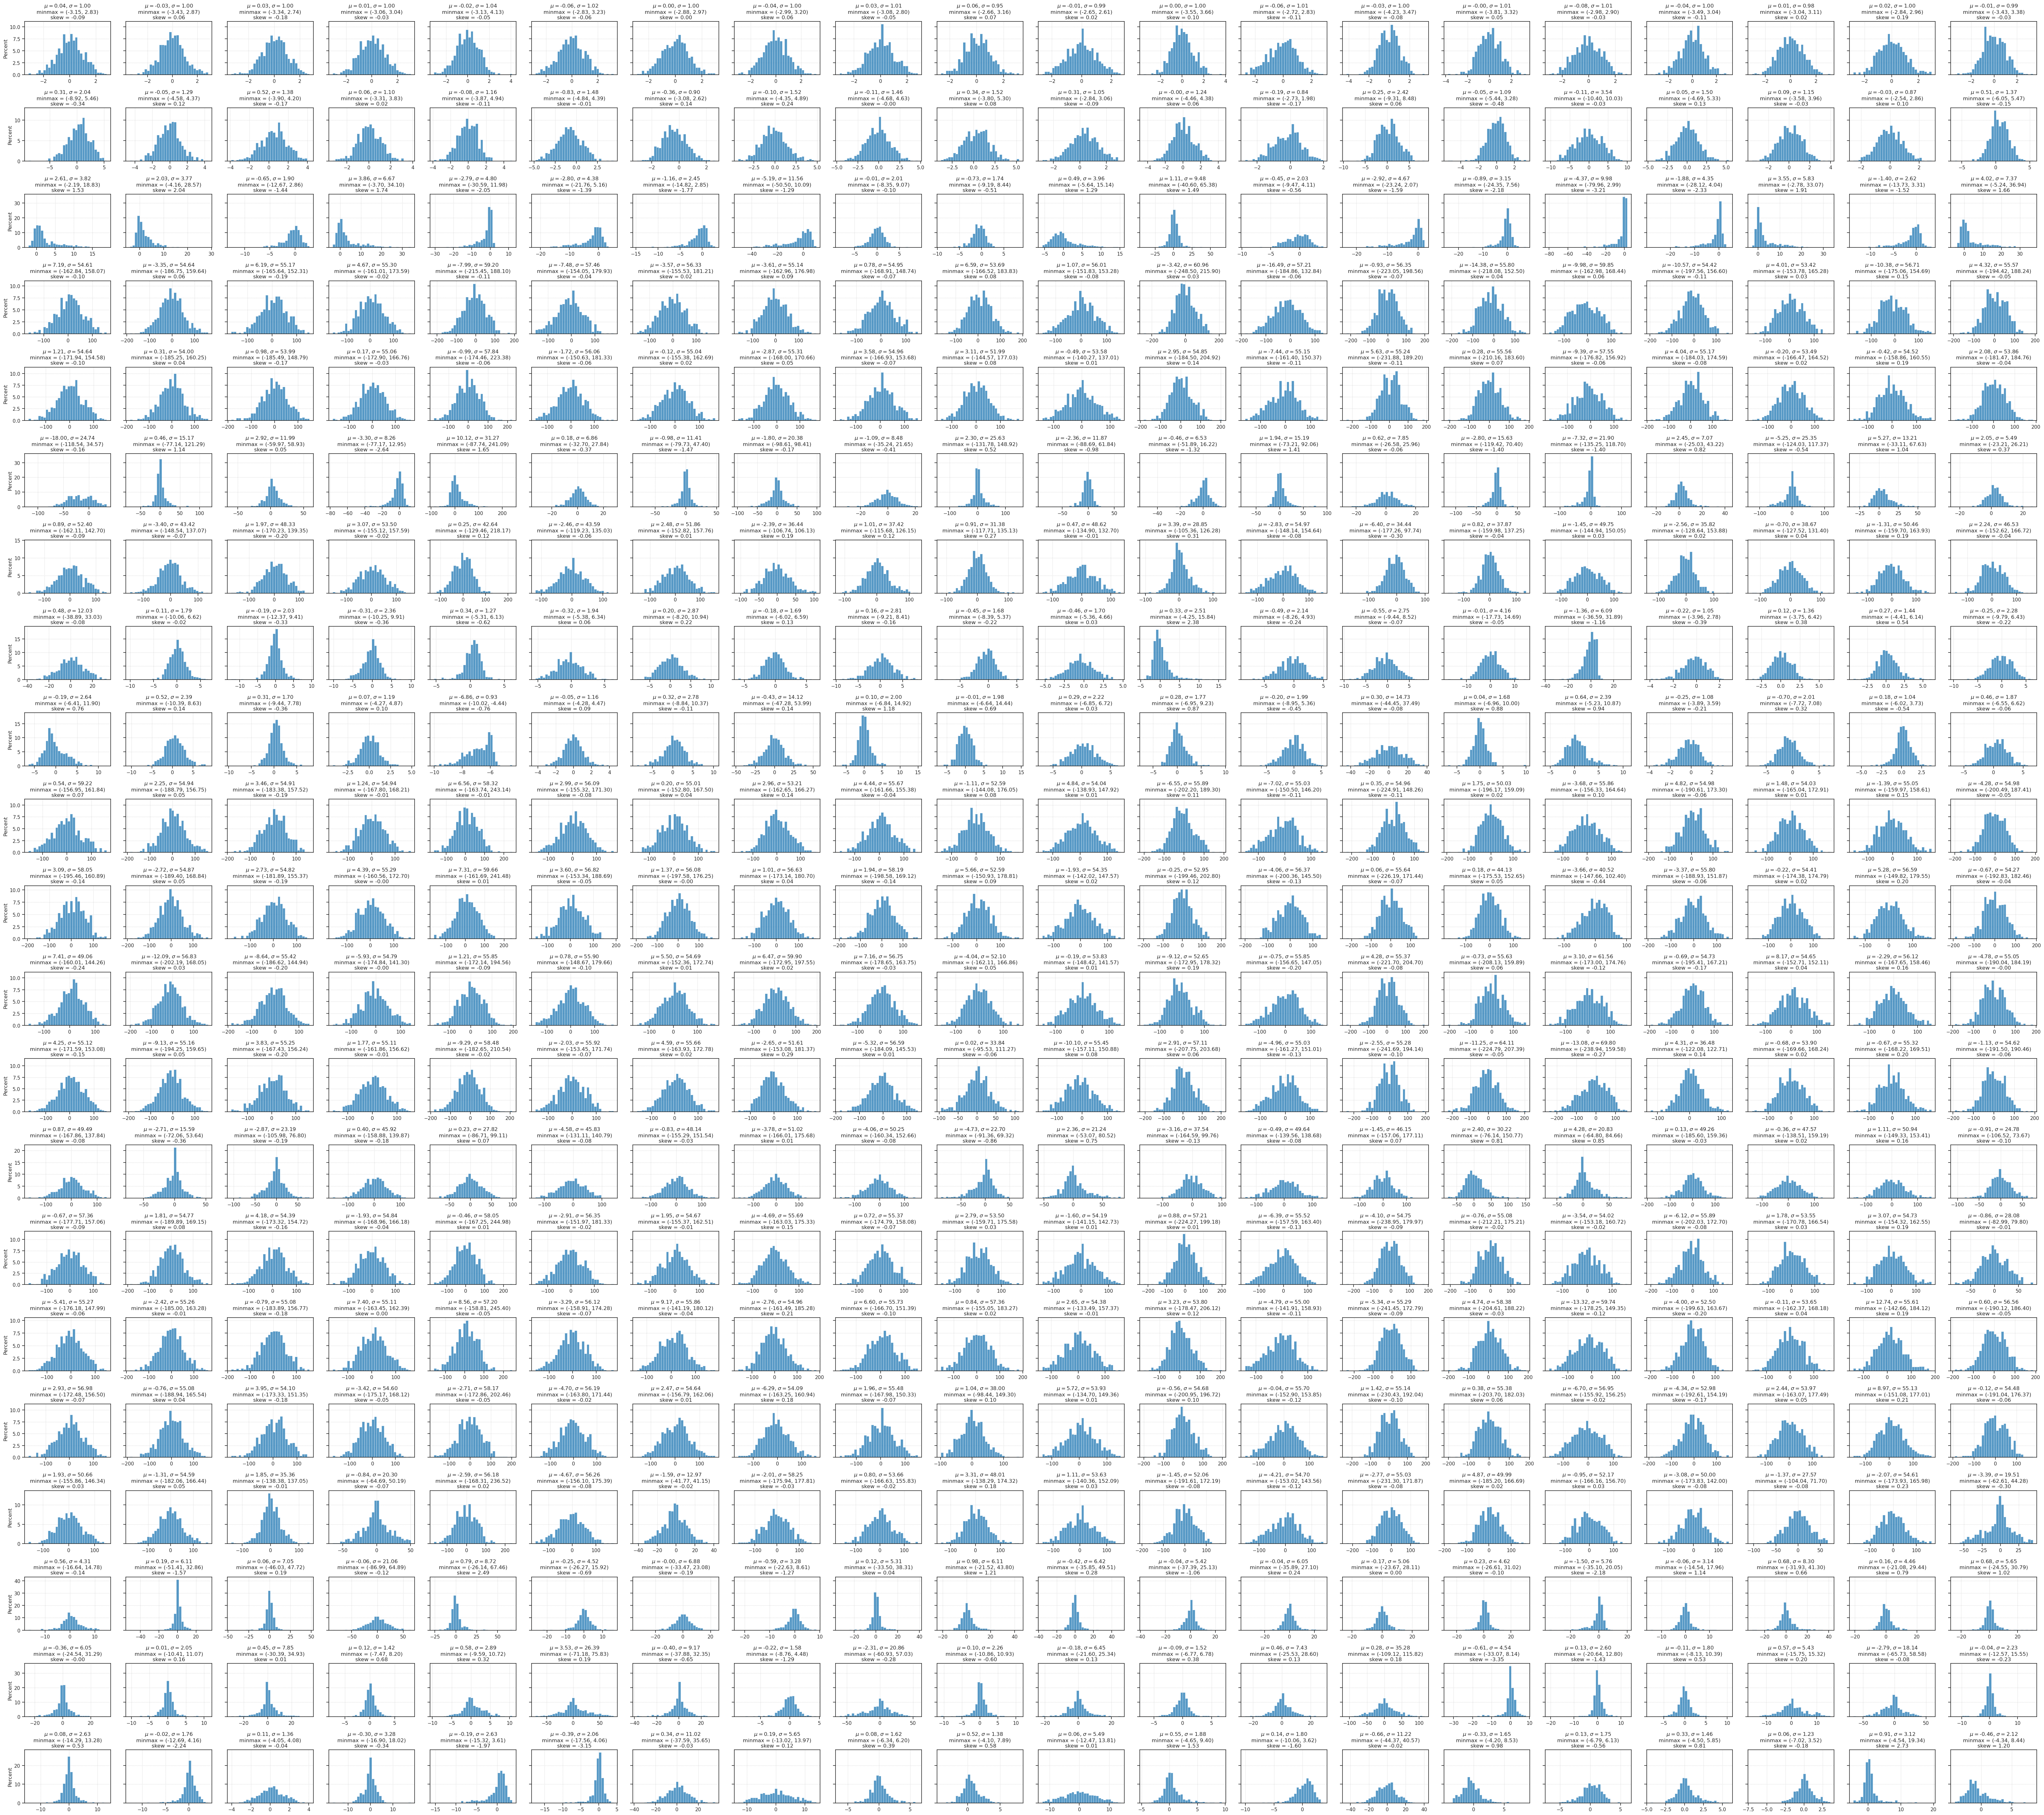

In [35]:
plot_latents_hist_full(val_low['z_sample'], scales);
plot_latents_hist_full(val_high['z_sample'], scales);

#### Pathological outlier samples ($\beta=0.15$)

(563, 199)

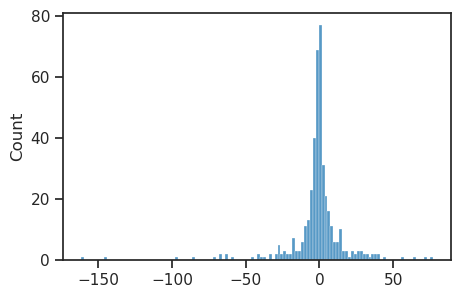

In [37]:
i, zz = np.unravel_index(np.argmin(val_low['z_sample']), val_low['z_sample'].shape)
sns.histplot(val_low['z_sample'][i]);
i, zz

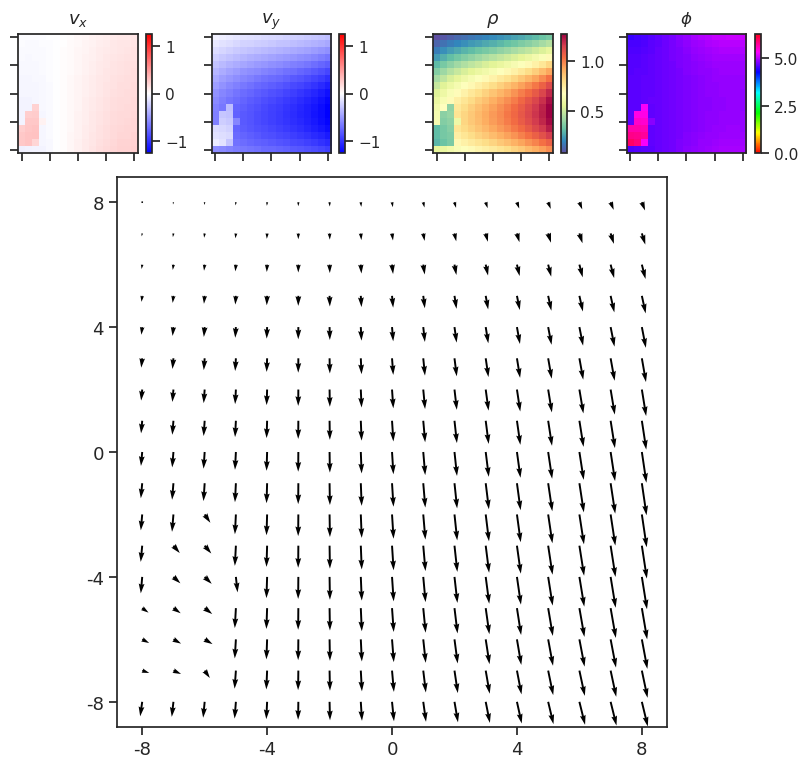

In [38]:
show_opticflow_full(val_low['x_sample'][i]);

(406, 184)

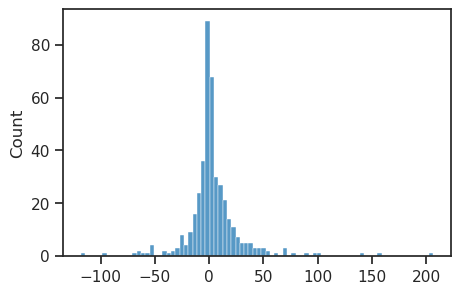

In [39]:
i, zz = np.unravel_index(np.argmax(val_low['z_sample']), val_low['z_sample'].shape)
sns.histplot(val_low['z_sample'][i]);
i, zz

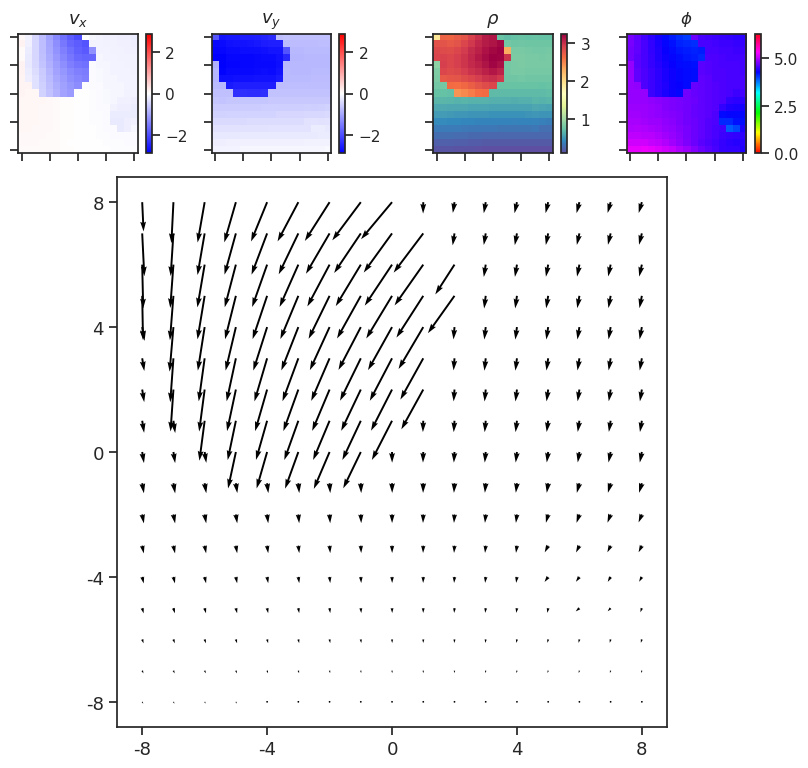

In [40]:
show_opticflow_full(val_low['x_sample'][i]);

#### Pathological outlier samples ($\beta=1$)

(587, 71)

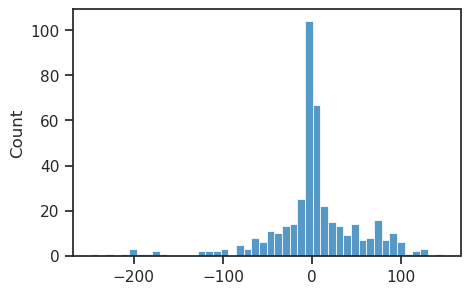

In [41]:
i, zz = np.unravel_index(np.argmin(val_high['z_sample']), val_high['z_sample'].shape)
sns.histplot(val_high['z_sample'][i]);
i, zz

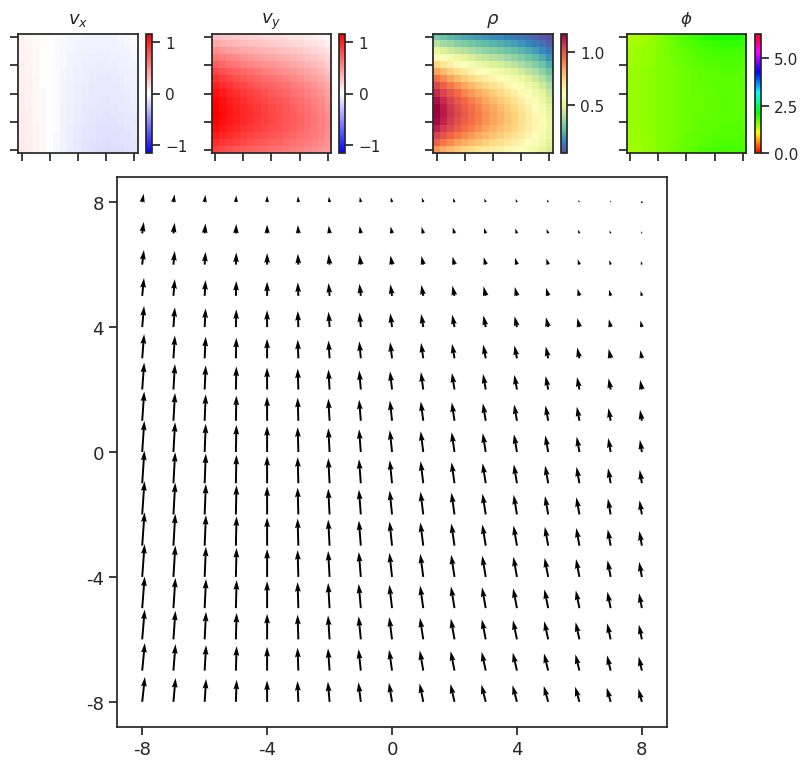

In [42]:
show_opticflow_full(val_high['x_sample'][i]);

(406, 304)

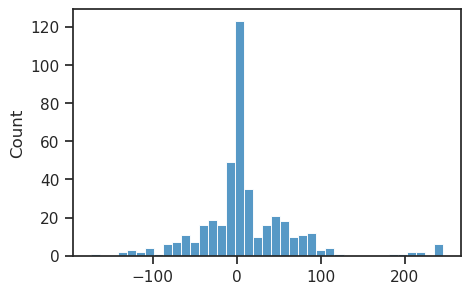

In [43]:
i, zz = np.unravel_index(np.argmax(val_high['z_sample']), val_high['z_sample'].shape)
sns.histplot(val_high['z_sample'][i]);
i, zz

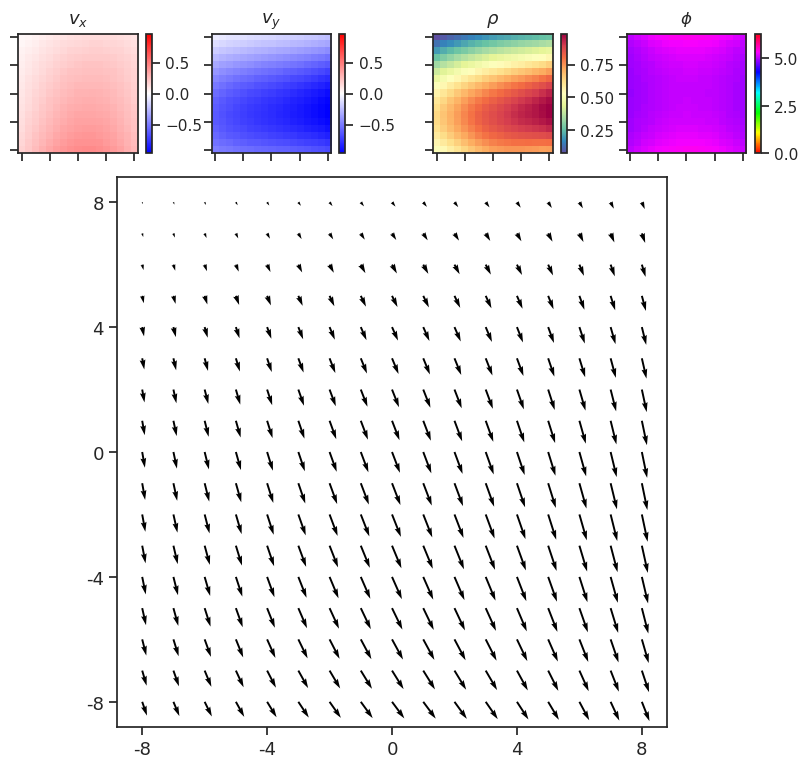

In [44]:
show_opticflow_full(val_high['x_sample'][i]);

### 7) Expand plots

#### $\beta = 0.15$

In [47]:
norms_expand = {}
for i, layer in enumerate(tr_low.model_ema.expand):
    _norm = to_np(torch.linalg.vector_norm(layer.weight, dim=[0, 2, 3]))
    norms_expand[i] = list(_norm)
print({i: (np.round(np.mean(v), 3), np.round(v, 3)) for i, v in norms_expand.items()})

{
    0: (
        0.329,
        array([0.767, 0.068, 0.683, 0.439, 0.838, 0.065, 0.558, 0.431, 0.066,
       0.067, 0.709, 0.066, 0.218, 0.343, 0.065, 0.066, 0.065, 0.334,
       0.066, 0.657], dtype=float32)
    ),
    1: (
        0.234,
        array([0.304, 0.334, 0.228, 0.326, 0.219, 0.278, 0.212, 0.32 , 0.258,
       0.337, 0.314, 0.045, 0.329, 0.051, 0.049, 0.342, 0.052, 0.335,
       0.046, 0.305], dtype=float32)
    ),
    2: (
        0.3,
        array([0.331, 0.348, 0.366, 0.351, 0.098, 0.372, 0.353, 0.365, 0.505,
       0.157, 0.441, 0.258, 0.347, 0.197, 0.2  , 0.136, 0.31 , 0.383,
       0.404, 0.08 ], dtype=float32)
    ),
    3: (
        0.345,
        array([1.003, 0.33 , 0.142, 0.145, 0.149, 0.543, 0.129, 0.13 , 0.15 ,
       0.171, 0.687, 0.184, 0.257, 0.9  , 0.275, 0.131, 0.601, 0.275,
       0.279, 0.409], dtype=float32)
    ),
    4: (
        0.408,
        array([0.234, 0.327, 0.28 , 0.291, 1.088, 0.253, 0.164, 0.274, 0.286,
       0.419, 0.35 , 0.895, 0.694, 0.443, 0.342, 0.186, 0.379, 0.195,
       0.77 , 0.285], dtype=float32)
    ),
    5: (
        0.339,
        array([0.31 , 0.148, 0.25 , 0.367, 0.141, 0.142, 1.206, 0.156, 0.8  ,
       0.358, 0.188, 0.357, 0.815, 0.178, 0.143, 0.303, 0.14 , 0.159,
       0.422, 0.195], dtype=float32)
    ),
    6: (
        0.415,
        array([0.159, 0.898, 0.292, 0.397, 1.278, 0.196, 0.177, 0.257, 0.238,
       0.164, 0.838, 0.164, 0.192, 0.262, 0.821, 0.386, 0.227, 0.861,
       0.313, 0.171], dtype=float32)
    ),
    7: (
        0.415,
        array([0.192, 0.211, 0.222, 0.258, 1.105, 0.35 , 0.2  , 0.364, 1.001,
       0.255, 0.843, 0.185, 0.205, 0.193, 0.282, 0.225, 0.189, 0.51 ,
       1.011, 0.5  ], dtype=float32)
    ),
    8: (
        0.695,
        array([0.649, 0.673, 0.394, 0.511, 0.584, 0.932, 0.462, 0.618, 1.237,
       1.281, 0.745, 0.405, 0.469, 1.348, 0.67 , 0.373, 0.661, 0.525,
       0.504, 0.86 ], dtype=float32)
    ),
    9: (
        0.444,
        array([0.285, 0.413, 1.494, 0.301, 0.299, 0.308, 1.784, 0.323, 0.281,
       0.297, 0.281, 0.3  , 0.424, 0.335, 0.307, 0.292, 0.316, 0.279,
       0.287, 0.282], dtype=float32)
    ),
    10: (
        0.391,
        array([0.271, 0.263, 2.109, 0.276, 0.275, 0.268, 0.283, 0.373, 0.301,
       0.329, 0.262, 0.266, 0.277, 0.272, 0.592, 0.263, 0.311, 0.27 ,
       0.265, 0.303], dtype=float32)
    ),
    11: (
        0.473,
        array([0.282, 0.267, 0.26 , 0.488, 0.282, 1.078, 1.066, 0.363, 0.294,
       0.316, 0.283, 0.265, 0.537, 0.281, 1.925, 0.352, 0.276, 0.268,
       0.284, 0.299], dtype=float32)
    ),
    12: (
        0.836,
        array([0.713, 1.116, 0.861, 0.95 , 0.696, 0.968, 0.987, 0.629, 0.783,
       1.214, 0.653, 0.96 , 0.861, 0.729, 0.871, 0.751, 0.654, 0.826,
       0.806, 0.686], dtype=float32)
    ),
    13: (
        0.582,
        array([0.531, 1.891, 0.408, 0.797, 0.41 , 0.341, 0.611, 0.741, 0.61 ,
       0.318, 0.574, 0.575, 0.535, 1.011, 0.403, 0.377, 0.372, 0.309,
       0.501, 0.325], dtype=float32)
    ),
    14: (
        0.73,
        array([0.611, 0.549, 0.499, 0.424, 0.616, 0.63 , 1.198, 0.494, 1.   ,
       1.05 , 1.027, 0.347, 0.583, 0.646, 0.375, 0.55 , 0.959, 1.008,
       1.367, 0.67 ], dtype=float32)
    ),
    15: (
        0.531,
        array([0.994, 0.595, 0.341, 0.272, 0.695, 0.231, 0.645, 0.245, 0.327,
       0.226, 0.394, 1.95 , 0.256, 0.642, 0.237, 0.374, 0.231, 0.751,
       0.333, 0.871], dtype=float32)
    ),
    16: (
        0.544,
        array([1.029, 0.288, 0.381, 0.381, 0.728, 0.374, 0.273, 0.442, 0.322,
       2.047, 0.411, 0.238, 0.256, 0.339, 0.417, 0.297, 0.234, 1.465,
       0.59 , 0.363], dtype=float32)
    ),
    17: (
        0.621,
        array([0.622, 0.395, 1.556, 0.365, 0.45 , 0.321, 0.366, 1.784, 1.497,
       0.375, 0.449, 0.313, 0.474, 0.427, 0.439, 0.46 , 0.319, 0.505,
       0.934, 0.365], dtype=float32)
    ),
    18: (
        1.19,
        array([1.13 , 1.425, 1.41 , 1.017, 1.674, 1.581, 0.839, 1.646, 0.832,
   

In [ ]:
scales, _ = tr_low.model.latent_scales()
num = tr_low.model.cfg.n_latent_per_group

for i, m in enumerate(tr_low.model_ema.expand):
    _w = to_np(m.weight)
    fig, axes = create_figure(num, num, (12, 8), 'all', 'all', tight_layout=True)
    for z, k in itertools.product(range(num), range(num)):
        ax = axes[z, k]
        im = ax.imshow(_w[z, k])
        plt.colorbar(im, ax=ax)
        if z == 0:
            ax.set_title(f"k = {k}", fontsize=13)
        if k == 0:
            ax.set_ylabel(f"z = {z}", fontsize=13)
    fig.suptitle(f'Expand_{i} (scale = {scales[i]})', fontsize=15, y=1.02)
    plt.show()